In [59]:
import os
import requests as req
from bs4 import BeautifulSoup
from typing import List
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
import gradio as gr
from IPython.display import Markdown, display, update_display
import json
from IPython.display import display

In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."


In [4]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")


In [5]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever a customer asks for a ticket price.",
    "input_schema": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to"
            }
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [6]:
tools = [price_function]

In [7]:
load_dotenv()
api_key = os.getenv("ANTHROPIC_API_KEY")
if not api_key:
    raise RuntimeError("Missing ANTHROPIC_API_KEY in .env")

from anthropic import Anthropic
client = Anthropic(api_key=api_key)
MODEL = "claude-sonnet-4-20250514"

In [7]:
def chat(message, history):
    anthro_messages = []
    for m in history:
         
         if m["role"] in ("user", "assistant"):
             
             anthro_messages.append({
                "role": m["role"],
                "content": [{"type": "text", "text": m["content"]}]
            })
                
   
     

   
    anthro_messages.append({"role": "user", "content": [{"type": "text", "text": message}]})


   
    response = client.messages.create(
        model=MODEL,
        max_tokens=500,
        system=system_message,
        tools=tools,
        messages=anthro_messages
    )

    tool_results = []
    for block in response.content:
        if block.type == "tool_use":
            tool_name = block.name
            tool_args = block.input
            tool_id = block.id
            
            result = get_ticket_price(tool_args["destination_city"])
            
            tool_results.append({
                "tool_use_id": tool_id,
                "content": json.dumps({"destination_city": tool_args["destination_city"], "price": result})
            })

   
    if not tool_results:
        
        return response.content[0].text

    
    followup = client.messages.create(
        model=MODEL,
        max_tokens=500,
        system=system_message,
        tools=tools,
        messages=[
            *anthro_messages,
            {"role": "assistant", "content": response.content},
            {"role": "user", "content": [
                {"type": "tool_result", "tool_use_id": tr["tool_use_id"], "content": tr["content"]}
                for tr in tool_results
            ]}
        ]
    )

    final_text = "".join(b.text for b in followup.content if b.type == "text")
    return final_text






In [8]:
def chat_ollama(message, history):
    messages = (
        [{"role": "system", "content": system_message}]
        + history
        + [{"role": "user", "content": message}]
    )

    resp = req.post(
        "http://localhost:11434/api/chat",
        json={
            "model": "llama3",
            "messages": messages,
            "stream": False
        }
    )

    data = resp.json()
    reply = data["message"]["content"] 
    # Check for tool call
    if "tool_calls" in data["message"] and len(data["message"]["tool_calls"]) > 0:
        tool_response, city = handle_tool_call_ollama(data["message"])
        messages.append(data["message"])  
        messages.append(tool_response)   
        
        resp2 = req.post(
            "http://localhost:11434/api/chat",
            json={
                "model": "llama3",
                "messages": messages,
                "stream": False
            }
        )
        data2 = resp2.json()
        reply = data2["message"]["content"]
    
    return reply

In [81]:
from PIL import Image
from io import BytesIO
from huggingface_hub import InferenceClient



In [64]:
def generate_image_prompt(city):
    
    prompt_response = client.messages.create(
        model=MODEL,
        max_tokens=100,
        system=img_prompt,
        messages=[{
            "role": "user",
            "content": f"Write a creative image prompt in one sentence for a vacation in {city}, vibrant pop-art style, tourist attractions included."
        }]
    )
    prompt = prompt_response.content[0].text.strip()

    
    response = req.post(
        HF_API_URL,
        headers=HF_HEADERS,
        json={"inputs": prompt}
    )

    if response.status_code != 200:
        raise Exception(f"HF Error {response.status_code}: {response.text}")

    return Image.open(BytesIO(response.content))


Generated prompt: A vibrant pop-art collage showcasing Lahore's iconic attractions with bold comic book colors and halftone patterns, featuring the majestic Badshahi Mosque in electric blues, the ornate Lahore Fort in hot pinks and yellows, bustling food streets with neon-bright kebabs and lassi, and tourists taking selfies against a backdrop of geometric shapes and Roy Lichtenstein-inspired speech bubbles saying "WOW!"


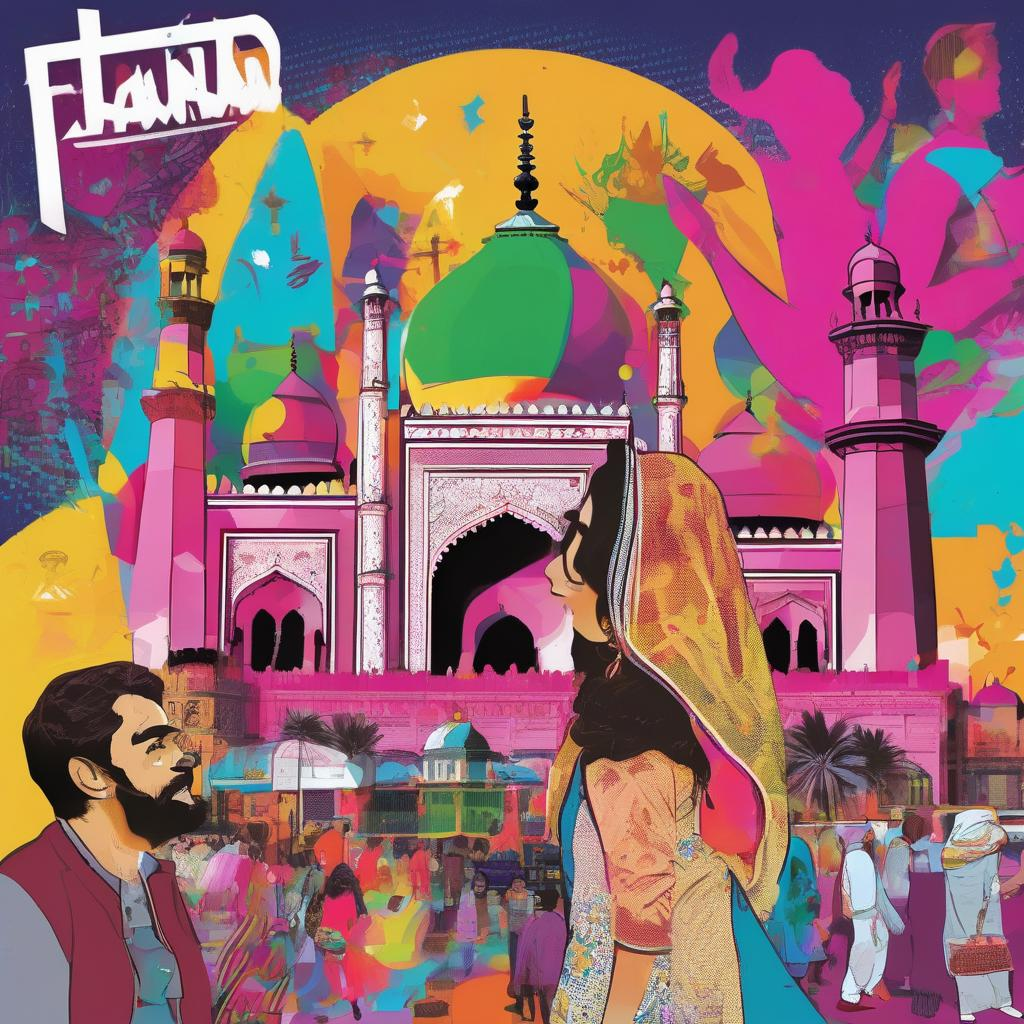

In [65]:
img = generate_image_prompt("Lahore")
print("Generated prompt:", prompt)
display(img)

<h1>Now adding image with chatbot along with user interface (Gradio) </h1>

In [79]:
def chat(history):
    if history is None:   
        history = []

    if not history:
        return history, None

    message = history[-1]["content"]

    anthro_messages = []
    for m in history:
        if m["role"] in ("user", "assistant"):
            anthro_messages.append({
                "role": m["role"],
                "content": [{"type": "text", "text": m["content"]}]
            })

    anthro_messages.append({"role": "user", "content": [{"type": "text", "text": message}]})

    response = client.messages.create(
        model=MODEL,
        max_tokens=500,
        system=system_message,
        tools=tools,
        messages=anthro_messages
    )

    tool_results = []
    image = None  
    for block in response.content:
        if block.type == "tool_use":
            tool_name = block.name
            tool_args = block.input
            tool_id = block.id
            
            result = get_ticket_price(tool_args["destination_city"])
            image = generate_image_prompt(tool_args["destination_city"])
            tool_results.append({
                "tool_use_id": tool_id,
                "content": json.dumps({
                    "destination_city": tool_args["destination_city"], 
                    "price": result
                })
            })

    if not tool_results:
        
        history += [{"role": "assistant", "content": response.content[0].text}]
        return history, None
    
    followup = client.messages.create(
        model=MODEL,
        max_tokens=500,
        system=system_message,
        tools=tools,
        messages=[
            *anthro_messages,
            {"role": "assistant", "content": response.content},
            {"role": "user", "content": [
                {"type": "tool_result", "tool_use_id": tr["tool_use_id"], "content": tr["content"]}
                for tr in tool_results
            ]}
        ]
    )

    final_text = "".join(b.text for b in followup.content if b.type == "text")
    history += [{"role": "assistant", "content": final_text}]
    return history, image


In [80]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        if history is None:
            history = []
        history += [{"role": "user", "content": message}]
        return "", history

    entry.submit(
        do_entry, 
        inputs=[entry, chatbot], 
        outputs=[entry, chatbot]
    ).then(
        chat, 
        inputs=[chatbot], 
        outputs=[chatbot, image_output]
    )

    clear.click(lambda: ([], None), inputs=None, outputs=[chatbot, image_output], queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for berlin
